In [2]:
!pip install cma

In [3]:
from stable_baselines3 import PPO
from CavityQubitEnv import CavityQubitEnv
import os
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import torch.nn as nn  # Import PyTorch for activation functions
from stable_baselines3.common.env_util import make_vec_env
import cma 
%matplotlib widget
# Wrap environment with Monitor for logging
log_dir = "./logs"
os.makedirs(log_dir, exist_ok=True)
# env = Monitor(PiPulseEnv(), log_dir)
# autoreload the environment if it changes
%load_ext autoreload
%autoreload 2

pulse_dir = "./pulses"
os.makedirs(pulse_dir, exist_ok=True)



# Load the pulse parameters

KeysView(NpzFile './pulses\\pulse_fock_0+2i.npz' with keys: I_q, Q_c, Q_q, times, chi...)


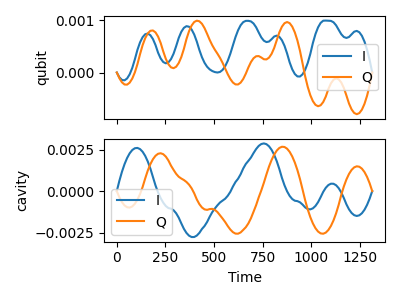

In [7]:
pulse_name = 'pulse_fock_0+2i.npz'
model_name = 'model_' + pulse_name.split('.')[0]
# open the pulse file
pulse_data = np.load(os.path.join(pulse_dir, pulse_name), allow_pickle=True)
print(pulse_data.keys())

_psi_0 = pulse_data['psi_0']
_psi_target = pulse_data['psi_target']
psi_0 = _psi_0[:len(_psi_0)//2] + 1j * _psi_0[len(_psi_0)//2:]
psi_target = _psi_target[:len(_psi_target)//2] + 1j * _psi_target[len(_psi_target)//2:]
Kc = float(pulse_data['Kc'])
Kq = float(pulse_data['Kq'])
chi = float(pulse_data['chi'])
cutoff_qubit = int(pulse_data['cutoff_qubit'])
cutoff_cavity = int(pulse_data['cutoff_cavity'])
psi_0 = qt.Qobj(psi_0, dims=[[cutoff_qubit, cutoff_cavity], [1]])
psi_target = qt.Qobj(psi_target, dims=[[cutoff_qubit, cutoff_cavity], [1]])


system_params = {
    'cutoff_qubit': cutoff_qubit,
    'cutoff_cavity': cutoff_cavity,
    'Kc': Kc * 0.90,
    'Kq': Kq * 0.90,
    'chi': chi * 1.15
}


Iq = pulse_data['I_q']
Qq = pulse_data['Q_q']
Ic = pulse_data['I_c']
Qc = pulse_data['Q_c']
times = pulse_data['times']
pulse_IQ = {
    'Iq': Iq,
    'Qq': Qq,
    'Ic': Ic,
    'Qc': Qc,
    'times': times
}
amplitude_bound_qb = max(np.max(np.abs(Iq)), np.max(np.abs(Qq)))*0.1
amplitude_bound_cav = max(np.max(np.abs(Ic)), np.max(np.abs(Qc)))*0.1
amplitude_bounds = [amplitude_bound_qb, amplitude_bound_cav]

fig, ax = plt.subplots(2, 1, figsize=(4, 3), sharex=True)
ax[0].plot(times, Iq, label='I')
ax[0].plot(times, Qq, label='Q')
ax[0].set_ylabel('qubit')
ax[0].legend()
ax[1].plot(times, Ic, label='I')
ax[1].plot(times, Qc, label='Q')
ax[1].set_ylabel('cavity')
ax[1].set_xlabel('Time')
ax[1].legend()
fig.tight_layout()


# Set up the model 

popsize=18
(9_w,18)-aCMA-ES (mu_w=5.4,w_1=30%) in dimension 112 (seed=289071, Wed Sep 17 11:30:20 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     18 9.749058901224394e-02 1.0e+00 9.65e-02  1e-01  1e-01 0:00.5
    2     36 9.251784438523891e-02 1.0e+00 9.39e-02  9e-02  9e-02 0:01.0
    3     54 8.431243698234991e-02 1.0e+00 9.21e-02  9e-02  9e-02 0:01.5
   10    180 5.302095540638929e-02 1.0e+00 8.84e-02  9e-02  9e-02 0:04.9
   19    342 2.557199748978123e-02 1.1e+00 9.51e-02  9e-02  1e-01 0:09.1
   30    540 1.530488753403680e-02 1.2e+00 1.08e-01  1e-01  1e-01 0:14.1
   44    792 1.000520090800094e-02 1.3e+00 1.15e-01  1e-01  1e-01 0:20.4
   60   1080 8.860521110389596e-03 1.4e+00 1.15e-01  1e-01  1e-01 0:27.6
   78   1404 7.940481634248764e-03 1.5e+00 1.13e-01  1e-01  1e-01 0:35.7
   99   1782 7.813997826368935e-03 1.5e+00 1.08e-01  1e-01  1e-01 0:45.1
  100   1800 8.375402618163497e-03 1.5e+00 1.08e-01  1e-01  1e-01 0:45.6
Best reward: -0.00623

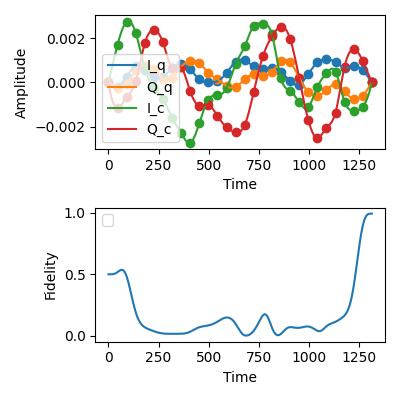

In [18]:
N_points = 30  # number of points of a pulse
nb_sample = None  # number of samples per wigner

env = CavityQubitEnv(
    psi_0=psi_0,
    psi_target=psi_target,
    system_params=system_params,
    pulse_IQ=pulse_IQ, 
    amplitude_bounds=amplitude_bounds,
    N_points=N_points,
    nb_sample=nb_sample
)

dim = env.action_space.shape[0]  # = 4*L
sigma0 = 0.1             # initial standard deviation
x0 = np.zeros(dim)               # initial mean (all zero actions)
popsize =(4 + int(3 * np.log(dim)))
print(f"popsize={popsize}")

# --- CMA-ES optimizer ---
# Popsize formula: 4 + floor(3*log(dim))
es = cma.CMAEvolutionStrategy(x0, sigma0, {
    "popsize": popsize,
    "bounds": [-1.0, 1.0],  # actions are clipped to [-1,1]
})
    
# --- Training loop ---
n_generations = 100
for gen in range(n_generations):

    solutions = es.ask()  # candidate solutions (list of action vectors)

    rewards = []
    for action in solutions:
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(1-reward)   # CMA-ES minimizes, so negate the reward
        # rewards.append(np.log(1-reward))   # CMA-ES minimizes, so negate the reward


    es.tell(solutions, rewards)  # update CMA-ES with evaluated candidates
    es.disp()                    # display progress

# --- Best solution ---
best_action = es.result.xbest
best_reward = -es.result.fbest

print("Best reward:", best_reward)

# Visualize with your render method
env.last_action = best_action
env.render()



Look at the fidelity per episode

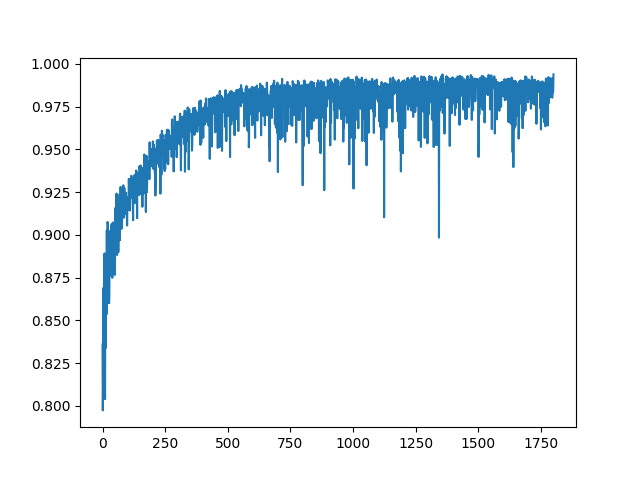

In [19]:
fig, ax = plt.subplots()
ax.plot(env.fid_list)